In [1]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

def cobaya_com(Dpar):
    return (10 - np.log(Cosmo_Power(Dpar,0.12,68,0.0546,0.964,2.01)))

def emcee_1(omc,omb,h,tau,ns,As):
    s = 10 - np.log(Cosmo_Power(omc,omb,h,tau,ns,As))
    print(s)
    return (s)

In [2]:
def emcee_2(o,h,tau,ns,As):
    s = 10 - np.log(Cosmo_Power(o[0],o[1],h,tau,ns,As))
    return (s)

ndim = 2 #number of parameters
nwalkers = 50 #steps to walk or try
import emcee #import parameter
omb = 0.1200 #parameter reference values
h = 68
tau = 0.0546
ns = 0.945
As = 2.0196
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_2, args=[h,tau,ns,As]) #samplers

p_initial = [] #initial staring points
for i in range(nwalkers): #iterate intial starting points for samplers which is dimension * walkers
    s = []
    p_initial.append([np.random.uniform(0.001,0.2000),np.random.uniform(0.001,1)]) #ramdom points with given range of points


In [3]:
state = sampler.run_mcmc(p_initial,100,progress = True)
sampler.reset()

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_24568\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_24568\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_24568\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp


emcee: Exception while calling your likelihood function:
  params: [0.05615293 0.40772613]
  args: [68, 0.0546, 0.945, 2.0196]
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [25]:
sampler.run_mcmc(state, 1000,progress = True);

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:40<00:00,  3.57it/s]


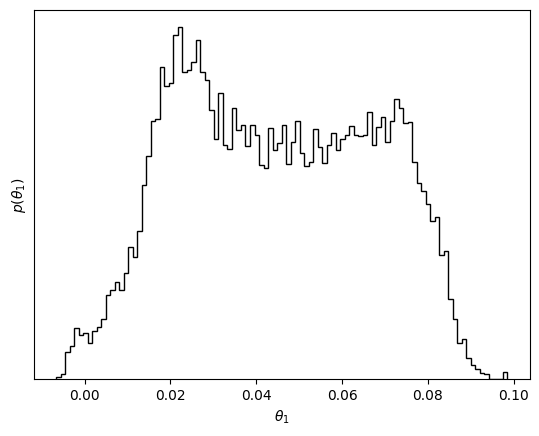

In [26]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [27]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

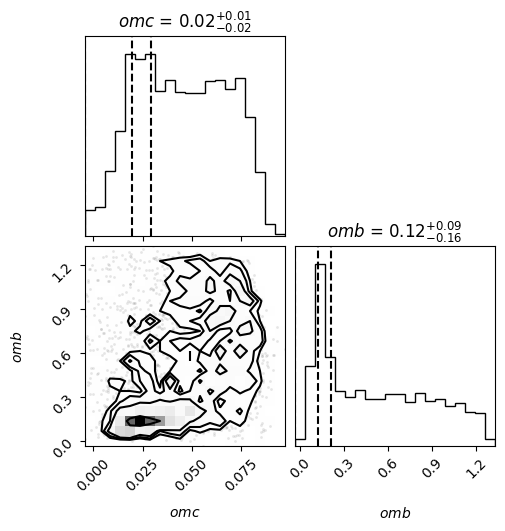

In [74]:
import corner

fig = corner.corner(
    flat_samples,
    labels=[
        r"$omc$",
        r"$omb$",

    ],
    quantiles=[0, 0.15, 0.3],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

In [62]:
value2 = np.argmax(flat_samples, axis=0)

In [67]:
print(flat_samples[value2[0]][1])

0.6237029820342179


In [75]:
def emcee_2(o,omb,tau,ns,As):
    s = 10 - np.log(Cosmo_Power(o[0],omb,o[1],tau,ns,As))
    return (s)

ndim = 2
nwalkers = 50

import emcee
omb = 0.1200
h = 68
tau = 0.0546
ns = 0.945
As = 2.0196
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_2, args=[omb,tau,ns,As])
p0 = np.random.rand(nwalkers, ndim)
p_initial = []
for i in range(nwalkers):
    s = []
    p_initial.append([np.random.uniform(0.001,0.2000),np.random.uniform(20,100)])
    
print(p_initial)

[[0.020437536193568636, 41.35482603288629], [0.13682055566207246, 78.52614240506213], [0.01933405404005547, 82.98863492037657], [0.1990088571080109, 94.06056870532323], [0.013203369513146865, 89.62502830051268], [0.10720753669546693, 32.490808311801274], [0.11365182827959588, 61.72063262526784], [0.07830252653037588, 21.813333897109715], [0.17916609921846616, 95.4326383108421], [0.04592998557583718, 35.372537925260126], [0.16955180527606278, 86.62800636079771], [0.058962578582625526, 64.55063984051982], [0.07908883884867968, 63.31024194489614], [0.08790065300436797, 34.192248752610716], [0.08354433956251388, 78.49376293411481], [0.009246716098690471, 82.84785497105358], [0.07830534960992083, 42.288824353222154], [0.11493188870248448, 44.37535606556429], [0.03524009746504612, 23.259002426355792], [0.02948310647895428, 77.74847803566337], [0.003365534562087375, 84.76037464154234], [0.18295707755421695, 63.34982366067475], [0.15190679113016906, 49.00625470471176], [0.0044299470996832305, 

In [76]:
state = sampler.run_mcmc(p_initial,100,progress = True)
sampler.reset()

D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:92: RuntimeWarning: overflow

In [77]:
sampler.run_mcmc(state, 2000,progress = True);

  0%|                                                                                 | 1/2000 [00:00<15:26,  2.16it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
  1%|▌                                                                               | 13/2000 [00:05<14:16,  2.32it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
  2%|█▋                                                                              | 43/2000 [00:18<14:20,  2.28it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_26524\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
  6%|████▍                                                               

In [78]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

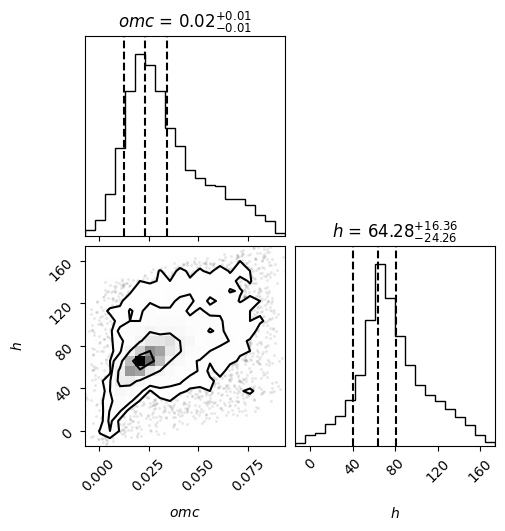

In [90]:
import corner

fig = corner.corner(
    flat_samples,
    labels=[
        r"$omc$",
        r"$h$",

    ],
    quantiles=[0.1, 0.35, 0.6],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

# 3 PArameter for emcee

In [61]:
def emcee_3(o,tau,ns,As):
    
    return (10 - np.log(Cosmo_Power(o[0],o[1],o[2],tau,ns,As)))

In [62]:
ndim = 3 #Number Of Dimension
nwalkers = 50 #Number of Walkers

import emcee #import Emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_3, args=[0.0546,0.968,2.0196])

p_initial = []
for i in range(nwalkers):
    s = []
    p_initial.append([np.random.uniform(0,0.1),
                      np.random.uniform(0,1),
                      np.random.uniform(0,100),
                     ])

In [63]:
state = sampler.run_mcmc(p_initial,100,progress = True)
sampler.reset()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,

In [65]:
sampler.run_mcmc(state, 1000,progress = True);

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_28572\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:54<00:00,  4.27it/s]


In [66]:
flat_samples3 = sampler.get_chain(discard=100, thin=15, flat=True)

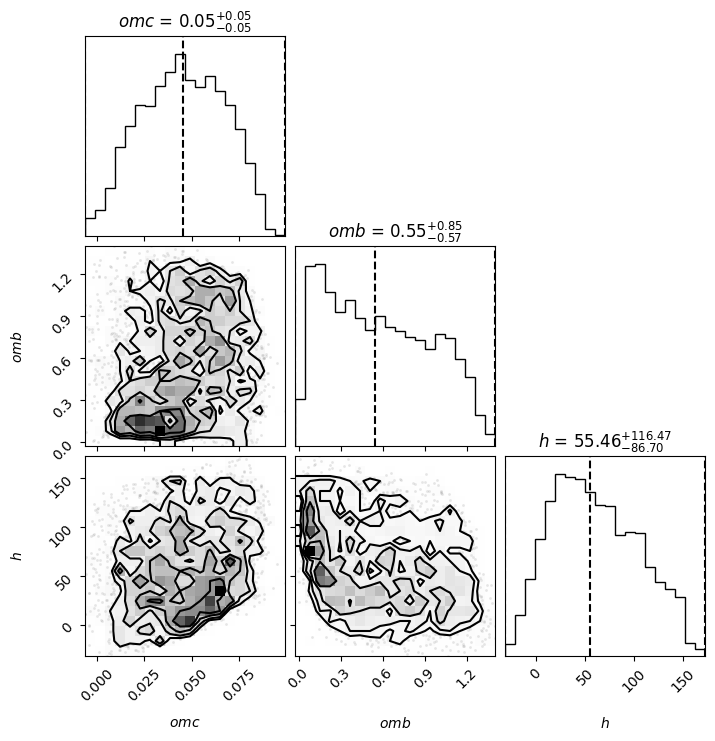

In [67]:
import corner

fig = corner.corner(
    flat_samples3,
    labels=[
        r"$omc$",
        r"$omb$",
        r"$h$",

    ],
    quantiles=[0, 0.5, 1],
    show_titles=True,
    somooth1d=10,
    title_kwargs={"fontsize": 12},
     divergences=True
);

In [68]:
from IPython.display import display, Math
labels = ["omc", "omb", "h","ns"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples3[:, i], [16,50,84])
    #print(np.quantile(flat_samples[:, i],[0.16,0.5,0.84]))
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
def emcee_4(o,tau,As):
    return (10 - np.log(Cosmo_Power(o[0],o[1],o[2],tau,o[3],As)))

In [13]:
ndim = 4 #Number Of Dimension
nwalkers = 100 #Number of Walkers

import emcee #import Emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_4, args=[0.0546,2.0196])

p_initial = []
for i in range(nwalkers):
    s = []
    p_initial.append([np.random.uniform(0,0.1),
                      np.random.uniform(0,1),
                      np.random.uniform(0,100),
                      np.random.uniform(0,1),
                     ])

In [14]:
state = sampler.run_mcmc(p_initial,200,progress = True)
sampler.reset()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,

In [15]:
sampler.run_mcmc(state, 1000,progress = True);

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\1540817400.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:09<00:00,  1.18it/s]


In [4]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
from multiprocessing import Pool
ndim = 4 #Number Of Dimension
nwalkers = 50 #Number of Walkers

import emcee #import Emcee

p_initial = []
for i in range(nwalkers):
    s = []
    p_initial.append([np.random.uniform(0,0.1),
                      np.random.uniform(0,1),
                      np.random.uniform(0,100),
                      np.random.uniform(0,1),
                     ])

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_4, args=[0.0546,2.0196], pool=pool )
    start = time.time()
    sampler.run_mcmc(p_initial, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

In [16]:
flat_samples = sampler.get_chain(discard=200, thin=2, flat=True)

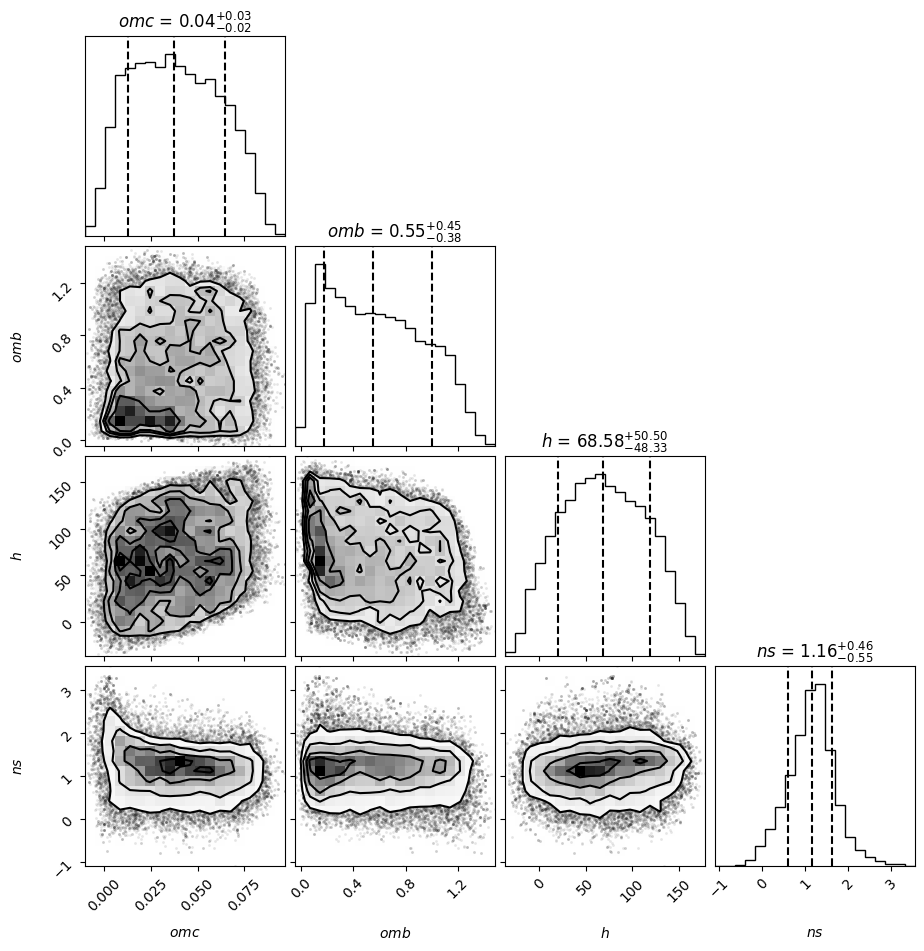

In [17]:
import corner

fig = corner.corner(
    flat_samples,
    labels=[
        r"$omc$",
        r"$omb$",
        r"$h$",
        r"$ns$",

    ],
    #truths=[0.022,0.12,68,0.968],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    somooth1d=10,
    title_kwargs={"fontsize": 12},
     divergences=True
);

In [18]:
from IPython.display import display, Math
labels = ["omc", "omb", "h","ns"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16,50,84])
    #print(np.quantile(flat_samples[:, i],[0.16,0.5,0.84]))
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [53]:
omc = np.quantile(flat_samples[:, 0],[0.16,0.5,0.84])
omb = np.quantile(flat_samples[:, 1],[0.16,0.5,0.84])
h = np.quantile(flat_samples[:, 2],[0.16,0.5,0.84])
ns = np.quantile(flat_samples[:, 3],[0.16,0.5,0.84])

In [25]:
flat_samples[:,0][np.argmin(flat_samples[:, 0])]

-0.010477537901535654

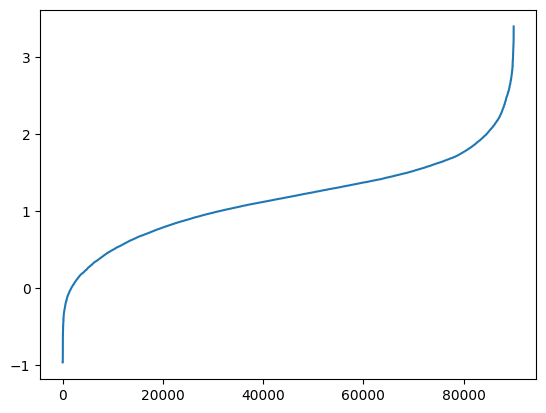

In [55]:
import matplotlib.pyplot as plt
x = range(2000)

plt.plot(np.sort(flat_samples[:, 3]))

In [2]:
def emcee_2(o,h,tau,ns,As):
    s = 10 - np.log(Cosmo_Power(o[0],o[1],h,tau,ns,As))
    return (s)

ndim = 2 #number of parameters
nwalkers = 50 #steps to walk or try
import emcee #import parameter
omb = 0.1200 #parameter reference values
h = 68
tau = 0.0546
ns = 0.945
As = 2.0196
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_2, args=[h,tau,ns,As]) #samplers

p_initial = [] #initial staring points
for i in range(nwalkers): #iterate intial starting points for samplers which is dimension * walkers
    s = []
    p_initial.append([np.random.uniform(0.001,0.2000),np.random.uniform(0.001,1)]) #ramdom points with given range of points
